Epoch 0, loss 0.16856203973293304
Epoch 1000, loss 1.0915469829342328e-05
Epoch 2000, loss 5.349301318346988e-06
Epoch 3000, loss 4.5191704884928185e-06
Epoch 4000, loss 2.8121864943386754e-06
Epoch 5000, loss 2.060071437881561e-06
Epoch 6000, loss 2.12228633245104e-06
Epoch 7000, loss 1.5441271443705773e-06
Epoch 8000, loss 1.3532422826756374e-06
Epoch 9000, loss 1.437092123524053e-06


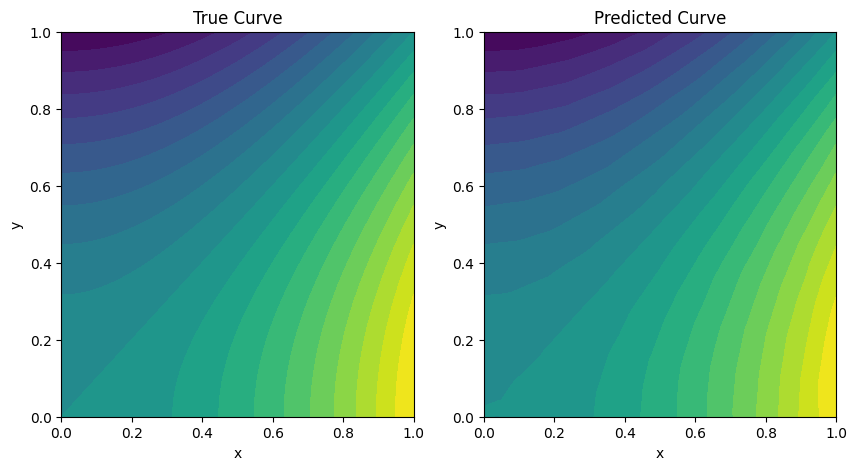

In [57]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Define the target function
def target_function(x, y):
    return x**2 - y**2


# Define the neural network architecture
class CurveFitter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(2, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the function to train the model
def train_model(model, train_input, train_target, num_epochs, optimizer, loss_fn):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_input)
        loss = loss_fn(output, train_target)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")


# Generate training data
train_input = torch.empty(1000, 2).uniform_(0, 1)
train_target = target_function(train_input[:, 0], train_input[:, 1]).unsqueeze(1)

# Define the model, loss function, and optimizer
model = CurveFitter()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_input, train_target, 10000, optimizer, loss_fn)

# Generate test input values
x_test = torch.linspace(0, 1, 100)
y_test = torch.linspace(0, 1, 100)
X, Y = torch.meshgrid(x_test, y_test)

# Compute curve predictions for test input values
test_input = torch.stack([X.flatten(), Y.flatten()], axis=1)
curve_predictions = model(test_input).detach().numpy().reshape(X.shape)

# Plot the true curve and predicted curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.contourf(X, Y, target_function(X, Y), levels=20, cmap='viridis')
ax.set_title('True Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the predicted curve
ax = fig.add_subplot(122)
ax.contourf(X, Y, curve_predictions, levels=20, cmap='viridis')
ax.set_title('Predicted Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Show the plot
plt.show()